# HoxHunt Summer Hunters 2021 - Data - Home assignment


<img src="http://hunters.hoxhunt.com/public/hero.svg" width="800">

## Assignment

In this assignment you as a HoxHunt Data Science Hunter are given the task to extract interesting features from a possible malicious indicator of compromise, more specifically in this case from a given potentially malicious URL. 

<img src="https://www.dropbox.com/s/ao0neaphtfama7g/Screenshot%202019-03-21%2017.23.40.png?dl=1" width="400">

This assignment assumes that you are comfortable (or quick to learn) on using Jupyter Notebooks and Python. You are free to use any external libraries you wish. We have included an example below using the Requests library.

Happy hunting!


## Interesting research papers & resources

Below is a list of interesting research papers on the topic. They might give you good tips what features you could extract from a given URL:


[Know Your Phish: Novel Techniques for Detecting
Phishing Sites and their Targets](https://arxiv.org/pdf/1510.06501.pdf)

[DeltaPhish: Detecting Phishing Webpages
in Compromised Websites](https://arxiv.org/pdf/1707.00317.pdf)

[PhishAri: Automatic Realtime Phishing Detection on Twitter](https://arxiv.org/pdf/1301.6899.pdf)

[More or Less? Predict the Social Influence of Malicious URLs on Social Media
](https://arxiv.org/abs/1812.02978)

[awesome-threat-intelligence](https://github.com/hslatman/awesome-threat-intelligence)



## What we expect

Investigate potential features you could extract from a given URL, and implement extractors for the ones that interest you the most. The example code below extracts one feature, but does not store it very efficiently (just console logs it). Implement a sensible data structure using some known data structure library to store the features per URL. Choose one feature for which you can visualise the results. What does the visualisation tell you? Also consider how you would approach error handling, if one of the feature extractor fails?

Should you make it to the next stage, be prepared to discuss the following topics: what features could indicate the malicousness of a given URL? What goes in to the thinking of the attacker when they are choosing a site for an attack? What inspired your solution and what would you develop next?

## What we don't expect

- That you implement a humangous set of features.
- That you implement any kind of actual predicition models that uses the features to give predictions on malicousness at this stage.

## Tips 


- Keep it tidy - a human is going to asses your work :)
- Ensure your program does not contain any unwanted behaviour
- What makes your solution stand out from the crowd?

In [1]:
import requests
import json
from urllib.parse import urlparse

database = dict()

def get_domain_age_in_days(domain):
    show = "https://input.payapi.io/v1/api/fraud/domain/age/" + domain
    data = requests.get(show).json()
    return data['result'] if 'result' in data else None

def parse_domain_from_url(url):
    t = urlparse(url).netloc
    return '.'.join(t.split('.')[-2:])

# Note some of these urls are live phishing sites (as of 2021-02-05) use with caution! More can be found at https://www.phishtank.com/
example_urls = [
    "https://www.slideshare.net/weaveworks/client-side-monitoring-with-prometheus",
    "https://intezasanpaolo.com/",
    "http://sec-login-device.com/",
    "http://college-eisk.ru/cli/",
    "https://dotpay-platnosc3.eu/dotpay/"
]

phishtank_data = requests.get('http://data.phishtank.com/data/online-valid.json')

In [2]:
index = {elem['url']: elem for elem in phishtank_data.json()}

In [3]:
# External validation: Phishtank
# Metadata validation: certificate issuer and existence
# Content validation: Top words from phishing sites -> counts

# Fast, explainable, modular, guides further development

from typing import List, Set, Dict, Tuple
from enum import IntEnum
from bs4 import BeautifulSoup
import string
import pandas as pd
from pandas import DataFrame

class Certificate(IntEnum):
    NoData = 1
    SelfSigned = 2
    ExternallyIssued = 3

def get_domain_age(url: str) -> int:
    # was given in the task, gets the age of domain
    age_in_days_feature = get_domain_age_in_days(parse_domain_from_url(url))
    return age_in_days_feature

def get_phishtank_report(url: str) -> int:
    # counts the number of reports for a given URL
    if url in index.keys():
        return len(index[url]['details'])
    return 0

def get_certificate_details(url: str) -> Certificate:
    # fetches certificate details and assigns a label from the following choices: no data, self-signed and externally issued
    if url[4] == 's':
        try:
            res = requests.get(url, verify=True)
            return Certificate.ExternallyIssued
        except:
            return Certificate.SelfSigned
    return Certificate.NoData

def parse_raw_text(raw: str) -> str:
    # text preprocessor, supersimple version. should remove special characters, make everything lowercase and standardized
    # a real version should have more functionality like stemming
    text = raw.replace('\n', ' ').strip()
    text = ' '.join(text.lower().split())
    text = ''.join(filter(lambda c: c in string.ascii_lowercase or c == ' ', text))
    return text

def sample_malicious_sites_for_words(n: int = 20) -> List[str]:
    # fetches the content of some malicious sites, preprocesses the text and counts word frequencies
    # the selection criteria for malicious site was the amount of reports in the phishtank db
    top_words = dict()
    top_malicious_sites = sorted(index.values(), key=lambda x: len(x['details']), reverse=True)
    top_malicious_sites = map(lambda domain: domain['url'], top_malicious_sites[:n])
    for domain in top_malicious_sites:
        try:
            res = requests.get(domain)
        except:
            continue
        content = BeautifulSoup(res.content)
        text = parse_raw_text(content.get_text())
        for word in text.split():
            if word in top_words.keys():
                top_words[word] += 1
            else:
                top_words[word] = 1
    return top_words

def word_frequencies(vocabulary: List[str], url: str) -> Dict[str, int]:
    # calculates the word frequencies for words which are present in the given vocabulary
    vocabulary = sorted(vocabulary.items(), key=lambda t: t[1], reverse=True)
    vocabulary = list(map(lambda t: t[0], vocabulary))
    frequencies = {word: 0 for word in vocabulary}
    res = requests.get(url)
    text = BeautifulSoup(res.content).get_text()
    text = parse_raw_text(text)
    for word in text.split():
        if word in frequencies.keys():
            frequencies[word] += 1
    return frequencies

def analyze_links(links: List[str]) -> DataFrame:
    # builds a dataframe that combines all features implemented above
    sample_vocabulary = sample_malicious_sites_for_words()
    columns = ['domain', 'domain_age', 'report_count', 'certificate_details']
    columns += list(sample_vocabulary.keys())
    #columns += list(map(lambda x: 'wordcount:' + x, sample_vocabulary.keys()))
    df = pd.DataFrame(columns=columns)
    for domain in example_urls:
        try:
            requests.get(domain)
        except:
            print(f'URL not accessible: {domain}')
            continue
        domain_age = get_domain_age(domain)
        phishtank_reports = get_phishtank_report(domain)
        certificate_details = get_certificate_details(domain)
        malicious_word_counts = word_frequencies(sample_vocabulary, domain)
        features = [domain, domain_age, phishtank_reports, int(certificate_details)]
        features += list(malicious_word_counts.values())
        df.loc[len(df)] = features
    return df

In [4]:
retrieved_data = analyze_links(example_urls)

URL not accessible: https://dotpay-platnosc3.eu/dotpay/


In [5]:
retrieved_data

,domain,domain_age,report_count,certificate_details,colourful,life,of,aij,here,we,...,webmailadmin,connected,exchang,corporation,link,is,currently,unavailable,mailbox,upgrade
0,https://www.slideshare.net/weaveworks/client-s...,5447,0,3,9,0,8,7,24,15,...,0,0,0,0,2,6,0,0,0,0
1,https://intezasanpaolo.com/,28,0,3,5,0,8,1,13,30,...,0,0,0,0,0,7,0,0,0,0
2,http://sec-login-device.com/,29,16,1,20,0,15,6,43,23,...,0,0,0,0,0,5,0,0,0,0
3,http://college-eisk.ru/cli/,3429,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
word_counts = retrieved_data.iloc[:, 4:]
total_counts = word_counts.sum()
total_frequencies = {col: total_counts[col] for col in word_counts.columns}

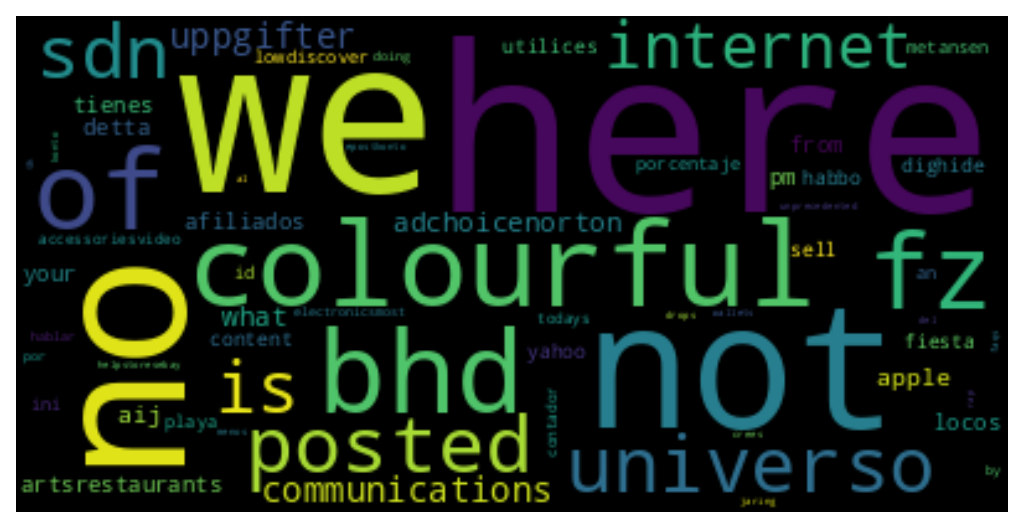

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(total_frequencies)
plt.figure(figsize=(8, 6), dpi=160)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()